## Ames Housing Dataset - ML Project - Martin Kihn / NYCDSA - January 2021
## Ames ML Project Features - Notebook #5

In [1]:
# This notebook is an exploration of feature importance using various
# models such as Ridge, Lasso, ElasticNet and XGBoost trees
# The goal is to get to a set of useful feature for the final model

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 2000)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

path_to_train = '~/Desktop/Ames_ML_Project/Data/final_df_01_18_9p_edited.csv'

In [2]:
df_train = pd.read_csv(path_to_train, index_col = False)
df_train.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
target_log = df_train['SalePrice_Log']
target = df_train['SalePrice']

In [4]:
X = df_train.copy()
X.drop(['SalePrice_Log', 'SalePrice'], axis=1, inplace=True)

In [5]:
target_log = list(target_log)
len(target_log)

1389

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1389 entries, 0 to 1388
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LotFrontage        1389 non-null   float64
 1   OverallQual        1389 non-null   float64
 2   OverallCond        1389 non-null   float64
 3   YearBuilt          1389 non-null   float64
 4   YearRemodAdd       1389 non-null   float64
 5   MasVnrArea         1389 non-null   float64
 6   TotalBsmtSF        1389 non-null   float64
 7   GrLivArea          1389 non-null   float64
 8   BedroomAbvGr       1389 non-null   float64
 9   TotRmsAbvGrd       1389 non-null   float64
 10  Fireplaces         1389 non-null   float64
 11  GarageArea         1389 non-null   float64
 12  WoodDeckSF         1389 non-null   float64
 13  OpenPorchSF        1389 non-null   float64
 14  MoSold             1389 non-null   float64
 15  YrSold             1389 non-null   float64
 16  Age                1389 

In [7]:
# want to create 2 dfs - one with continuous vars - one with cats
# these will be X_nums and X_cats

In [78]:
X_num_cols = X.dtypes[X.dtypes != 'int64'].index

In [79]:
X_nums = X[X_num_cols]

In [80]:
X_nums.shape

(1389, 19)

In [81]:
X_cats_cols = X.dtypes[X.dtypes != 'float64'].index
X_cats = X[X_cats_cols]

In [82]:
X_cats.shape

(1389, 61)

In [38]:
# target_log, X_nums, X_cats

Text(0.5, 1.0, 'SalePrice_Log Normalized')

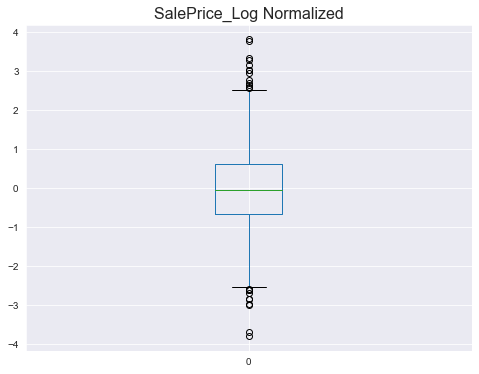

In [147]:
# first let's do the histplot
fig, ax = plt.subplots(figsize=(8,6))
pd.DataFrame(target_log).boxplot()
ax.set_title("SalePrice_Log Normalized", fontsize=16)

Text(0.5, 1.0, 'Continuous Features - Correlations')

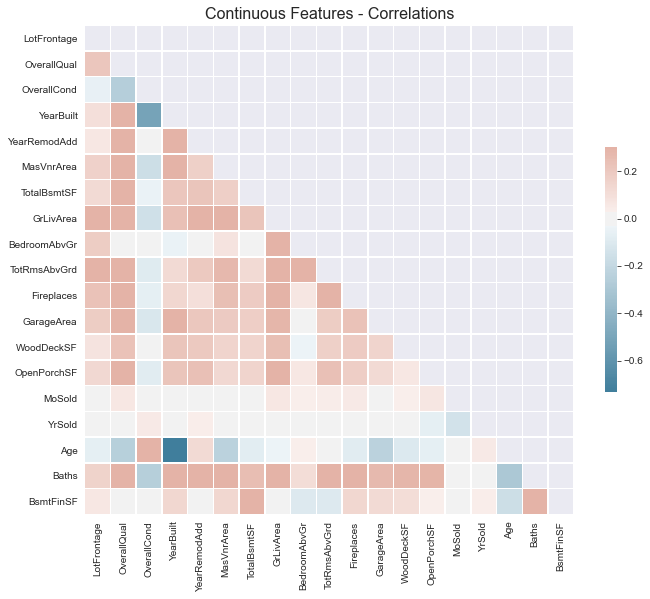

In [148]:
corr = X_nums.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, \
           square=True, linewidths=0.5, cbar_kws={'shrink': 0.5})
ax.set_title('Continuous Features - Correlations', fontsize=16)

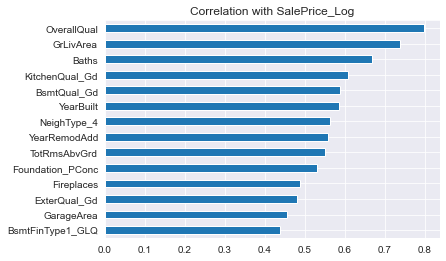

In [7]:
# also show correlation with SalePrice_Log as a chart [look in book1]

corrmat = df_train.drop('SalePrice', axis=1).corr()
corrmat_sp = corrmat['SalePrice_Log'].sort_values(ascending=False)
corrmat_sp[1:15].plot(kind = "barh", title="Correlation with SalePrice_Log").invert_yaxis()

In [11]:
df_corrmat_sp = pd.DataFrame(corrmat_sp)
df_corrmat_sp.head()

,SalePrice_Log
SalePrice_Log,1.000000
OverallQual,0.797266
GrLivArea,0.738920
Baths,0.666657
KitchenQual_Gd,0.607390


In [208]:
# next: do ols, lasso, ridge, elasticnet w/ CV
# then do: RF, XGB
# feature pruning/selection
# final model -> then the app

In [273]:
# these are features to consider removing - hardly related to target
corrmat_sp[(corrmat_sp < 0.28) & (corrmat_sp > -0.3)]

LotShape_IR1         0.238549
MasVnrType_Brick     0.215867
NeighType_3          0.210710
RoofStyle_Oth        0.196265
BsmtFinSF            0.195520
2Story_Y             0.153716
BldgType_1Fam        0.142313
LotShape_IR2         0.132740
ExterCond_Avg        0.121917
BedroomAbvGr         0.100195
Exterior_CemntBd     0.085420
LotConfig_Oth        0.084754
MoSold               0.064826
LandSlope_Oth        0.056593
LotShape_IR3         0.029469
LandContour_Oth      0.025565
ExterCond_Ex        -0.019255
Exterior_Other      -0.019504
LandContour_Lvl     -0.025565
YrSold              -0.032621
LandSlope_Gtl       -0.056593
Exterior_WdShing    -0.067891
BsmtFinType1_ALQ    -0.082859
Exterior_BrkComm    -0.084500
LotConfig_Inside    -0.084754
Exterior_HdBoard    -0.085145
BsmtFinType1_LwQ    -0.088788
ExterCond_Gd        -0.120298
RoadRail_Yes        -0.121985
BsmtFinType1_Rec    -0.131327
BsmtFinType1_BLQ    -0.138030
BldgType_Oth        -0.142313
BsmtFinType1_None   -0.153855
OverallCon

In [274]:
# consideration for features is: how useful are they in predicting
# and also: can I use them in the app?

In [12]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()

In [15]:
ridge.set_params(alpha=1)
ridge.fit(X, target_log)
print('The Ridge intercept is: %.2f' % (ridge.intercept_))
df_ridge_coef = pd.DataFrame(pd.Series(ridge.coef_, index=X.columns).sort_values(ascending=False), \
columns=['Coef'])

The Ridge intercept is: 0.19


In [26]:
df_ridge_coef.columns = ['Coef_Ridge']
df_ridge_coef.head()

,Coef_Ridge
GrLivArea,0.370273
NeighType_4,0.241809
BsmtFinType1_None,0.237145
GarageType_None,0.207133
OverallQual,0.206847


In [17]:
alphas = np.linspace(1, 100, 20)
ridge.set_params(normalize=False)
coefs_ridge = []

for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X, target_log)
    print(r'The alpha is %.2f' %alpha)
    print(r'The R^2 is %.2f' %(ridge.score(X, target_log)))
    coefs_ridge.append(ridge.coef_)

The alpha is 1.00
The R^2 is 0.90
The alpha is 6.21
The R^2 is 0.90
The alpha is 11.42
The R^2 is 0.90
The alpha is 16.63
The R^2 is 0.90
The alpha is 21.84
The R^2 is 0.90
The alpha is 27.05
The R^2 is 0.90
The alpha is 32.26
The R^2 is 0.90
The alpha is 37.47
The R^2 is 0.90
The alpha is 42.68
The R^2 is 0.90
The alpha is 47.89
The R^2 is 0.90
The alpha is 53.11
The R^2 is 0.90
The alpha is 58.32
The R^2 is 0.90
The alpha is 63.53
The R^2 is 0.90
The alpha is 68.74
The R^2 is 0.90
The alpha is 73.95
The R^2 is 0.89
The alpha is 79.16
The R^2 is 0.89
The alpha is 84.37
The R^2 is 0.89
The alpha is 89.58
The R^2 is 0.89
The alpha is 94.79
The R^2 is 0.89
The alpha is 100.00
The R^2 is 0.89


In [18]:
coefs_ridge = pd.DataFrame(coefs_ridge, index = alphas, columns =\
                          X.columns)

In [19]:
coefs_ridge.iloc[:10,]

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,Age,Baths,BsmtFinSF,MSZoning_Oth,MSZoning_RL,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Lvl,LandContour_Oth,LotConfig_Inside,LotConfig_Oth,LandSlope_Gtl,LandSlope_Oth,BldgType_1Fam,BldgType_Oth,RoofStyle_Gable,RoofStyle_Oth,MasVnrType_Brick,MasVnrType_Oth,ExterQual_Avg,ExterQual_Ex,ExterQual_Gd,ExterCond_Avg,ExterCond_Ex,ExterCond_Gd,Foundation_CBlock,Foundation_Oth,Foundation_PConc,BsmtQual_Avg,BsmtQual_Gd,BsmtExposure_Yes,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,HeatingQC_Avg,HeatingQC_Gd,CentralAir_Yes,Electrical_Yes,KitchenQual_Avg,KitchenQual_Gd,GarageType_Attchd,GarageType_None,GarageType_Oth,PavedDrive_Yes,Fence_Yes,2Story_Y,RoadRail_Yes,Exterior_BrkComm,Exterior_CemntBd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Other,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing,NeighType_2,NeighType_1,NeighType_3,NeighType_4
1.000000,0.025218,0.206847,0.129970,0.068309,0.068734,0.008635,0.107884,0.370273,-0.004643,0.014978,0.059411,0.154518,0.026596,0.010678,0.002747,-0.018517,-0.026079,0.048833,0.202511,-0.063863,0.063863,0.028248,0.164303,-0.220882,0.028331,0.005919,-0.005919,-0.005537,0.005537,-0.027542,0.027542,0.063364,-0.063364,-0.017544,0.017544,-0.015747,0.016310,-0.020429,0.073591,-0.053162,0.006708,0.053933,-0.060642,-0.022640,-0.041889,0.064530,-0.359775,-0.358177,0.079277,-0.039084,-0.038761,-0.026107,-0.104765,0.237145,-0.028427,-0.013500,0.013500,0.139228,-0.008361,-0.011622,0.011622,-0.101959,0.207133,-0.105174,0.039972,-0.037829,-0.149654,-0.138696,-0.544272,0.078194,0.017530,0.098115,0.101327,0.092134,0.065755,0.091217,-0.152355,-0.193605,-0.005974,0.241809
6.210526,0.028188,0.209614,0.128690,0.069238,0.069001,0.012427,0.065410,0.370760,-0.006991,0.020229,0.060756,0.112911,0.027967,0.012268,0.002977,-0.019217,-0.026996,0.055882,0.153164,-0.063917,0.063917,0.010505,0.131269,-0.151645,0.009871,0.005860,-0.005860,-0.006019,0.006019,-0.028672,0.028672,0.062457,-0.062457,-0.019366,0.019366,-0.017763,0.019787,-0.021644,0.072066,-0.050422,0.024637,0.020658,-0.045296,-0.023822,-0.040302,0.064124,-0.092763,-0.086347,0.079501,-0.023320,-0.022939,-0.010836,-0.080226,0.148478,-0.011155,-0.014242,0.014242,0.129370,0.003105,-0.013408,0.013408,-0.041315,0.089137,-0.047822,0.034793,-0.037915,-0.167893,-0.133387,-0.201386,0.030927,-0.029546,0.051045,0.055934,0.042530,0.017541,0.032954,-0.121861,-0.164861,0.012745,0.257491
11.421053,0.030217,0.210762,0.127275,0.069892,0.069669,0.014777,0.060903,0.362801,-0.008047,0.024325,0.062115,0.101996,0.028692,0.012960,0.003345,-0.019360,-0.027237,0.059039,0.128602,-0.063428,0.063428,0.002785,0.112612,-0.116256,0.000859,0.005423,-0.005423,-0.006385,0.006385,-0.029189,0.029189,0.061546,-0.061546,-0.020830,0.020830,-0.019045,0.020924,-0.021369,0.068753,-0.047384,0.028578,0.012260,-0.040839,-0.024176,-0.039013,0.063189,-0.060130,-0.049682,0.078960,-0.015699,-0.015670,-0.003093,-0.066763,0.104798,-0.003572,-0.014870,0.014870,0.121156,0.007050,-0.014761,0.014761,-0.023631,0.056106,-0.032476,0.033733,-0.037212,-0.164342,-0.129302,-0.123011,0.020810,-0.039276,0.040235,0.045883,0.029572,0.006802,0.018985,-0.111888,-0.154788,0.014461,0.253281
16.631579,0.031977,0.211542,0.125825,0.070501,0.070373,0.016706,0.059692,0.354660,-0.008716,0.027988,0.063399,0.097169,0.029224,0.013508,0.003683,-0.019387,-0.027392,0.061029,0.114259,-0.062928,0.062928,-0.001163,0.100070,-0.094562,-0.004344,0.004790,-0.004790,-0.006637,0.006637,-0.029323,0.029323,0.060522,-0.060522,-0.022012,0.022012,-0.020079,0.021444,-0.021176,0.065713,-0.044537,0.029972,0.008574,-0.038546,-0.024385,-0.037739,0.062124,-0.047964,-0.033853,0.078216,-0.011463,-0.011827,0.001424,-0.057771,0.079249,0.000389,-0.015441,0.015441,0.113982,0.009272,-0.015992,0.015992,-0.014644,0.040150,-0.025506,

In [92]:
coefs_ridge.iloc[:1,].T.sort_values(by=[1], ascending=False)

,1.0
GrLivArea,0.370273
NeighType_4,0.241809
BsmtFinType1_None,0.237145
GarageType_None,0.207133
OverallQual,0.206847
BsmtFinSF,0.202511
LotShape_IR2,0.164303
GarageArea,0.154518
CentralAir_Yes,0.139228
OverallCond,0.129970


In [20]:
alphas = np.linspace(0.01, 0.2, 20)
lasso.set_params(normalize=False)
coefs_lasso = []

for alpha in alphas:
    lasso.set_params(alpha=alpha)
    lasso.fit(X, target_log)
    print(r'The alpha is %.2f' %alpha)
    print(r'The R^2 is %.2f' %(lasso.score(X, target_log)))
    coefs_lasso.append(lasso.coef_)
    
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = \
                          X.columns)

The alpha is 0.01
The R^2 is 0.89
The alpha is 0.02
The R^2 is 0.87
The alpha is 0.03
The R^2 is 0.86
The alpha is 0.04
The R^2 is 0.86
The alpha is 0.05
The R^2 is 0.85
The alpha is 0.06
The R^2 is 0.85
The alpha is 0.07
The R^2 is 0.84
The alpha is 0.08
The R^2 is 0.83
The alpha is 0.09
The R^2 is 0.83
The alpha is 0.10
The R^2 is 0.82
The alpha is 0.11
The R^2 is 0.81
The alpha is 0.12
The R^2 is 0.81
The alpha is 0.13
The R^2 is 0.80
The alpha is 0.14
The R^2 is 0.79
The alpha is 0.15
The R^2 is 0.78
The alpha is 0.16
The R^2 is 0.77
The alpha is 0.17
The R^2 is 0.76
The alpha is 0.18
The R^2 is 0.75
The alpha is 0.19
The R^2 is 0.74
The alpha is 0.20
The R^2 is 0.73


In [95]:
coefs_lasso.sort_values(by=['OverallQual'], axis=0, ascending=False).iloc[:10]

,LotFrontage,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,GrLivArea,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,Age,Baths,BsmtFinSF,MSZoning_Oth,MSZoning_RL,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Lvl,LandContour_Oth,LotConfig_Inside,LotConfig_Oth,LandSlope_Gtl,LandSlope_Oth,BldgType_1Fam,BldgType_Oth,RoofStyle_Gable,RoofStyle_Oth,MasVnrType_Brick,MasVnrType_Oth,ExterQual_Avg,ExterQual_Ex,ExterQual_Gd,ExterCond_Avg,ExterCond_Ex,ExterCond_Gd,Foundation_CBlock,Foundation_Oth,Foundation_PConc,BsmtQual_Avg,BsmtQual_Gd,BsmtExposure_Yes,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,HeatingQC_Avg,HeatingQC_Gd,CentralAir_Yes,Electrical_Yes,KitchenQual_Avg,KitchenQual_Gd,GarageType_Attchd,GarageType_None,GarageType_Oth,PavedDrive_Yes,Fence_Yes,2Story_Y,RoadRail_Yes,Exterior_BrkComm,Exterior_CemntBd,Exterior_HdBoard,Exterior_MetalSd,Exterior_Other,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_WdShing,NeighType_2,NeighType_1,NeighType_3,NeighType_4
0.20,0.000000,0.350376,0.0,0.062463,0.014338,0.0,0.000000,0.245636,0.0,0.0,0.000000,0.020081,0.0,0.0,0.0,-0.0,-0.0,0.093516,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.19,0.000000,0.350089,0.0,0.065759,0.018984,0.0,0.000000,0.250939,0.0,0.0,0.000000,0.026151,0.0,0.0,0.0,-0.0,-0.0,0.095013,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.18,0.000000,0.348227,0.0,0.069453,0.024392,0.0,0.001138,0.254299,0.0,0.0,0.006115,0.031578,0.0,0.0,0.0,-0.0,-0.0,0.095864,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.17,0.000000,0.345310,0.0,0.073297,0.029515,0.0,0.007211,0.257782,0.0,0.0,0.012163,0.036599,0.0,0.0,0.0,-0.0,-0.0,0.096113,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.16,0.000086,0.342395,0.0,0.077135,0.034644,0.0,0.013279,0.261234,0.0,0.0,0.018203,0.041614,0.0,0.0,0.0,-0.0,-0.0,0.096370,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.15,0.006640,0.339648,0.0,0.080489,0.040168,0.0,0.019026,0.262381,0.0,0.0,0.023765,0.046110,0.0,0.0,0.0,-0.0,-0.0,0.097346,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.14,0.013187,0.336901,0.0,0.083858,0.045691,0.0,0.024776,0.263544,0.0,0.0,0.029327,0.050604,0.0,0.0,0.0,-0.0,-0.0,0.098304,0.000000,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0
0.13,0.019557,0.334488,0.0,0.087286,0.051585,0

In [99]:
coefs_lasso.iloc[:1,].T.sort_values(by=[0.01], ascending=False)

,0.01
GrLivArea,0.374660
OverallQual,0.257456
NeighType_4,0.224133
YearBuilt,0.154035
OverallCond,0.106009
GarageArea,0.088202
BsmtFinSF,0.073340
Fireplaces,0.071443
YearRemodAdd,0.070988
TotalBsmtSF,0.059006


In [21]:
df_lasso_coefs = coefs_lasso.iloc[:1,].T.sort_values(by=[0.01], ascending=False)

In [27]:
df_lasso_coefs.columns = ['Coef_Lasso']

In [28]:
df_lasso_coefs.head()

,Coef_Lasso
GrLivArea,0.374660
OverallQual,0.257456
NeighType_4,0.224133
YearBuilt,0.154035
OverallCond,0.106009


In [29]:
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5, normalize=False)
elasticnet.fit(X, target_log)
print(r'The R^2 is %.2f' %(elasticnet.score(X, target_log)))
coefs_elasticnet = pd.DataFrame(elasticnet.coef_, index=X.columns.T)

The R^2 is 0.85


In [30]:
coefs_elasticnet = coefs_elasticnet.rename(columns={0 : 'Coef'})
coefs_elasticnet.Coef.sort_values(ascending = False)[:15]

OverallQual       0.304331
GrLivArea         0.277793
YearBuilt         0.113810
YearRemodAdd      0.103646
GarageArea        0.086035
Baths             0.082022
Fireplaces        0.074511
LotFrontage       0.069895
TotalBsmtSF       0.059949
BsmtFinSF         0.056418
WoodDeckSF        0.025548
MasVnrArea        0.007700
OverallCond       0.004994
MasVnrType_Oth    0.000000
ExterQual_Avg    -0.000000
Name: Coef, dtype: float64

In [31]:
from sklearn.model_selection import GridSearchCV

parametersGrid = {"alpha" : [0.001, 0.01, 0.1, 1],
                 "l1_ratio" : np.arange(0.1, 1.0, 0.1)}
enet = ElasticNet()
grid = GridSearchCV(enet, parametersGrid, cv=10)
grid.fit(X, target_log)

enet_grid = pd.DataFrame(grid.cv_results_)

In [32]:
enet_grid.sort_values(by=['rank_test_score'])[:10]
# winner is alpha 0.01, l1 ratio 0.2
# scores 90-91

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
10,0.005600,0.000347,0.001950,0.000257,0.01,0.2,"{'alpha': 0.01, 'l1_ratio': 0.2}",0.911163,0.916399,0.903705,0.861202,0.906571,0.888586,0.896099,0.907490,0.759799,0.888377,0.883939,0.044010,1
9,0.007846,0.001367,0.001946,0.000176,0.01,0.1,"{'alpha': 0.01, 'l1_ratio': 0.1}",0.910881,0.916980,0.903393,0.859898,0.907456,0.890433,0.896257,0.907192,0.758491,0.887537,0.883852,0.044510,2
8,0.024682,0.002002,0.002035,0.000246,0.001,0.9,"{'alpha': 0.001, 'l1_ratio': 0.9}",0.911017,0.917117,0.900786,0.859725,0.909199,0.890242,0.896627,0.905769,0.760259,0.886360,0.883710,0.043956,3
11,0.005374,0.000288,0.001969,0.000252,0.01,0.3,"{'alpha': 0.01, 'l1_ratio': 0.30000000000000004}",0.911297,0.915537,0.903602,0.861811,0.905455,0.887038,0.896048,0.907506,0.759217,0.888520,0.883603,0.044015,4
7,0.023645,0.001373,0.002047,0.000201,0.001,0.8,"{'alpha': 0.001, 'l1_ratio': 0.8}",0.910988,0.917110,0.900681,0.859403,0.909269,0.890399,0.896374,0.905660,0.759908,0.886104,0.883589,0.044058,5
6,0.020736,0.001775,0.002005,0.000104,0.001,0.7,"{'alpha': 0.001, 'l1_ratio': 0.7000000000000001}",0.910913,0.917084,0.900556,0.859074,0.909190,0.890539,0.896085,0.905538,0.759477,0.885841,0.883430,0.044167,6
5,0.020768,0.004842,0.002146,0.000234,0.001,0.6,"{'alpha': 0.001, 'l1_ratio': 0.6}",0.910773,0.917039,0.900395,0.858741,0.909118,0.890621,0.895732,0.905406,0.758335,0.885569,0.883173,0.044467,7
12,0.005754,0.000412,0.001908,0.000244,0.01,0.4,"{'alpha': 0.01, 'l1_ratio': 0.4}",0.911245,0.914543,0.902918,0.861709,0.904592,0.885421,0.895721,0.907209,0.758066,0.888507,0.882993,0.044161,8
4,0.020733,0.002731,0.002376,0.000258,0.001,0.5,"{'alpha': 0.001, 'l1_ratio': 0.5}",0.910673,0.916979,0.900201,0.858434,0.909070,0.890686,0.895370,0.905311,0.756914,0.885307,0.882895,0.044846,9
3,0.016951,0.002099,0.002083,0.000188,0.001,0.4,"{'alpha': 0.001, 'l1_ratio': 0.4}",0.910604,0.917027,0.900011,0.858159,0.909038,0.890835,0.894974,0.905262,0.754951,0.885159,0.882602,0.045392,10


In [33]:
elasticnet = ElasticNet(alpha=0.01, l1_ratio=0.2, normalize=False)
elasticnet.fit(X, target_log)
print(r'The R^2 is %.2f' %(elasticnet.score(X, target_log)))
coefs_elasticnet = pd.DataFrame(elasticnet.coef_, index=X.columns.T)

The R^2 is 0.90


In [42]:
coefs_elasticnet = coefs_elasticnet.rename(columns={0 : 'Coef'})
df_elasticnet_coef = pd.DataFrame(coefs_elasticnet.Coef.sort_values(ascending = False))

In [44]:
df_elasticnet_coef.columns = ['Coef_Elastic']
df_elasticnet_coef.head()

,Coef_Elastic
GrLivArea,0.366912
NeighType_4,0.250810
OverallQual,0.221791
OverallCond,0.122999
YearBuilt,0.121307


In [35]:
# remove all the vars that are = 0 or close to 0 - no impact

In [85]:
# do a gradient boosting model now to see what it says about features

from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(max_features = 'sqrt', \
	learning_rate = 0.01)
depth= [3, 4, 5]
n_est = [1100, 1200]
grid_param = [{'max_depth' : depth, 'n_estimators' : n_est}]
n_folds = 5
clf = GridSearchCV(gbm, grid_param, cv = n_folds, n_jobs = -1)
clf.fit(X, target_log)
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 4, 'n_estimators': 1200}
0.9064420499869165


In [86]:
gbm = GradientBoostingRegressor(max_features = 'sqrt', learning_rate=0.01, \
                                max_depth = 4, n_estimators = 1200)
gbm.fit(X, target_log)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, max_features='sqrt',
                          n_estimators=1200)

In [87]:
pd.Series(gbm.feature_importances_).sort_values(ascending=False)[0:10,]

1     0.141431
7     0.109338
6     0.074730
11    0.057856
3     0.052467
17    0.051363
59    0.049637
10    0.044096
47    0.038295
9     0.036359
dtype: float64

In [138]:
gbm_df = pd.DataFrame(gbm.feature_importances_, index=X.columns.T)
gbm_df.columns = ['FI_GBM']
gbm_df.head()

,FI_GBM
LotFrontage,0.015592
OverallQual,0.141431
OverallCond,0.007704
YearBuilt,0.052467
YearRemodAdd,0.029363


In [141]:
gbm_df = gbm_df.sort_values(by=['FI_GBM'], ascending=False)
gbm_df.head()

,FI_GBM
OverallQual,0.141431
GrLivArea,0.109338
TotalBsmtSF,0.074730
GarageArea,0.057856
YearBuilt,0.052467


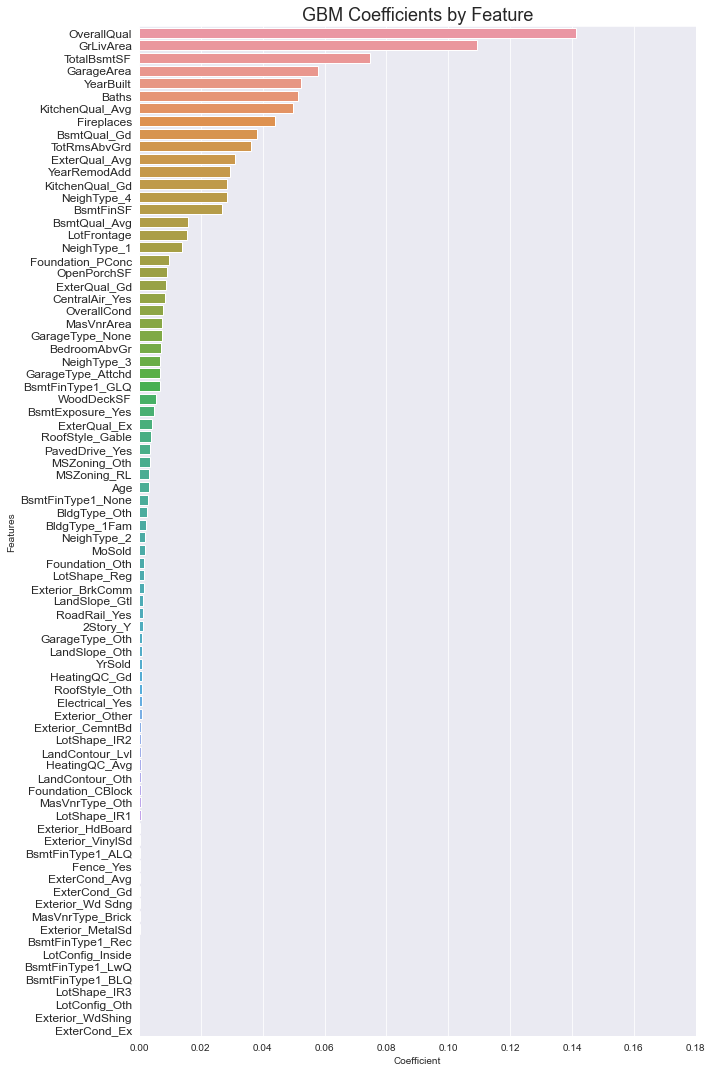

In [153]:
f, ax = plt.subplots(figsize=(10, 15))
fig = sns.barplot(x = 'FI_GBM', y = gbm_df.index, data=gbm_df, orient='h')
fig.axis(xmin=0, xmax=0.18)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Features", fontsize=10)
ax.set_xlabel("Coefficient", fontsize=10)
ax.set_title('GBM Coefficients by Feature', fontsize=18)
plt.tight_layout()

plt.show()

In [150]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

In [151]:
xgb = XGBRegressor(n_estimators=500, colsample_bytree = 0.3, max_depth = 4)
xgb.fit(X, target_log)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

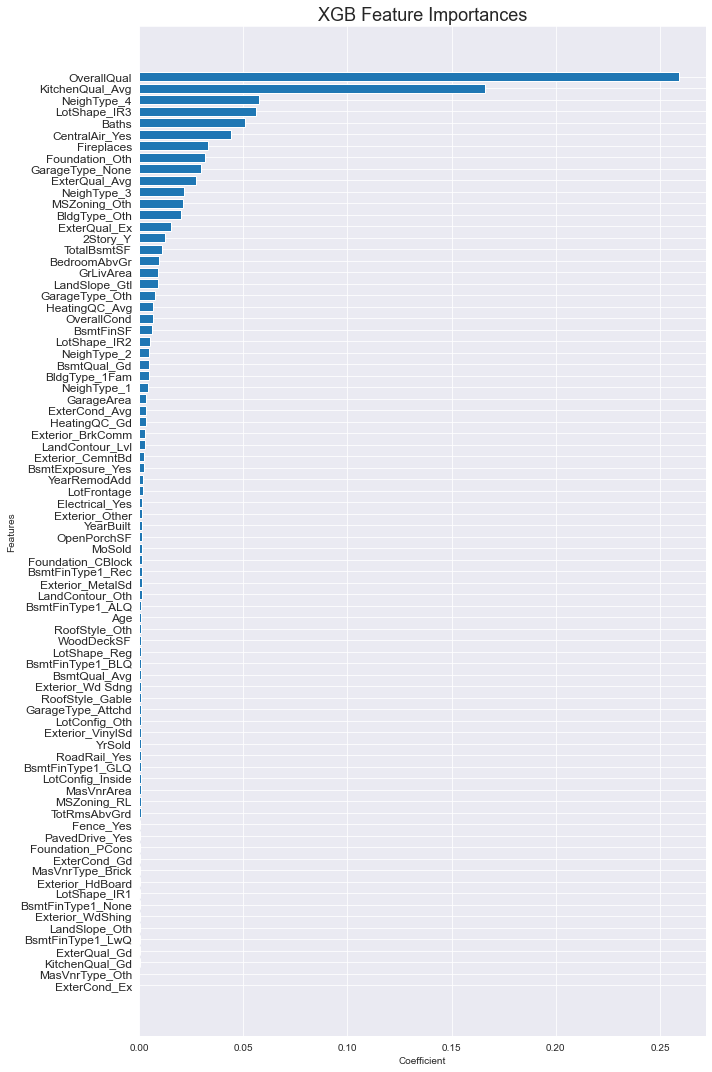

In [152]:
sorted_idx = xgb.feature_importances_.argsort()
f, ax = plt.subplots(figsize=(10,15))
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Features", fontsize=10)
ax.set_xlabel("Coefficient", fontsize=10)
ax.set_title('XGB Feature Importances', fontsize=18)
plt.tight_layout()

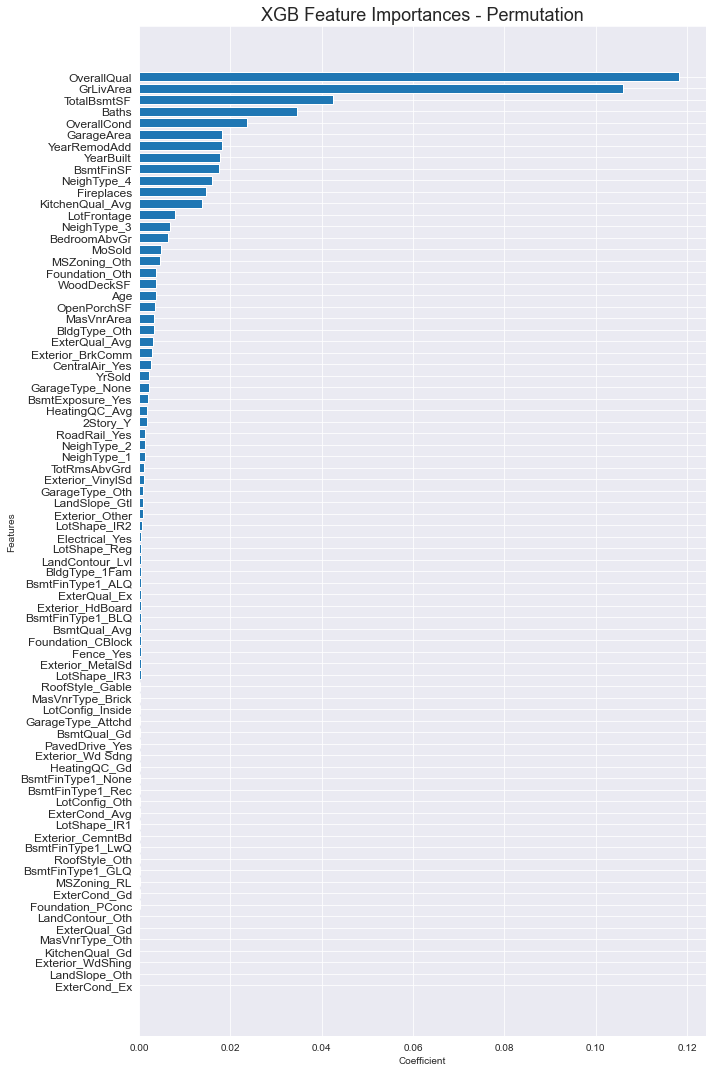

In [154]:
# let's try a different type of feature importance - permutation importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(xgb, X, target_log)
sorted_idx = perm_importance.importances_mean.argsort()

f, ax = plt.subplots(figsize=(10,15))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel("Features", fontsize=10)
ax.set_xlabel("Coefficient", fontsize=10)
ax.set_title('XGB Feature Importances - Permutation', fontsize=18)
plt.tight_layout()

In [155]:
# these values are much better (above) - more intuitive - I'll use these for
# feature selection

In [156]:
fi_xgb_sorted = list(zip(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx]))
fi_xgb_sorted_df = pd.DataFrame(fi_xgb_sorted, columns=['Feature', 'FI'])
fi_xgb_sorted_df.sort_values(by = 'FI', ascending = False)

,Feature,FI
79,OverallQual,0.118147
78,GrLivArea,0.106057
77,TotalBsmtSF,0.042407
76,Baths,0.034512
75,OverallCond,0.023547
74,GarageArea,0.018235
73,YearRemodAdd,0.018171
72,YearBuilt,0.017681
71,BsmtFinSF,0.017477
70,NeighType_4,0.016088


In [162]:
pi_xgb_df = fi_xgb_sorted_df.copy()
pi_xgb_df.columns = ['Feature', 'PI_XGB']

In [169]:
pi_xgb_df = pi_xgb_df.sort_values(by=['PI_XGB'], ascending=False)
pi_xgb_df.head()

,PI_XGB
Feature,
OverallQual,0.118147
GrLivArea,0.106057
TotalBsmtSF,0.042407
Baths,0.034512
OverallCond,0.023547


In [172]:
pi_xgb_df.index.name = None
pi_xgb_df.head()

,PI_XGB
OverallQual,0.118147
GrLivArea,0.106057
TotalBsmtSF,0.042407
Baths,0.034512
OverallCond,0.023547


In [157]:
egb = XGBRegressor(verbosity = 0, eta = 0.01)
depth = [2, 3, 4]
n_est = [600]
csby = [0.2, 0.3]
lb = [0.0000001]

In [158]:
grid_params = [{'max_depth' : depth, 'n_estimators' : n_est, \
               'colsample_bytree' : csby, 'lambda' : lb}]
n_folds = 5
clf = GridSearchCV(egb, grid_params, cv = n_folds, n_jobs = -1)
clf.fit(X, target_log)
print(clf.best_params_)
print(clf.best_score_)

{'colsample_bytree': 0.3, 'lambda': 1e-07, 'max_depth': 4, 'n_estimators': 600}
0.8998556836254803


In [159]:
scores = cross_val_score(XGBRegressor(objective='reg:squarederror'), X, \
                        target_log, scoring='neg_mean_squared_error')

In [160]:
(-scores)**0.5

array([0.31158955, 0.41548557, 0.35195401, 0.30551815, 0.39465397])

In [161]:
print(pd.DataFrame(clf.cv_results_))

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.748472      0.003927         0.007663        0.000421   
1       0.951997      0.005540         0.009336        0.000136   
2       1.167126      0.003156         0.012017        0.000879   
3       0.903503      0.003500         0.007263        0.000055   
4       1.168841      0.055511         0.009151        0.000279   
5       1.155509      0.094137         0.007747        0.000244   

  param_colsample_bytree param_lambda param_max_depth param_n_estimators  \
0                    0.2        1e-07               2                600   
1                    0.2        1e-07               3                600   
2                    0.2        1e-07               4                600   
3                    0.3        1e-07               2                600   
4                    0.3        1e-07               3                600   
5                    0.3        1e-07               4                600  

In [173]:
# so much for the models - I will now look at the features again
# and decide how to prune them for my final model & my app
# all the ML models appear to be equally accurate - so 90%R2 is
# as good as it gets - let me see how few vars I can use to get there
# also I want to use ElasticNet as my model since it came up with the
# most intuitive output to me & is easy to interpret

In [174]:
# I will combine my df's now so all the coefficients and scores
# are in the same df by feature
from functools import reduce

In [198]:
data_frames = [df_corrmat_sp, df_ridge_coef, df_lasso_coefs, \
              df_elasticnet_coef, gbm_df, pi_xgb_df]

df_merged = pd.concat(data_frames, axis=1, sort=False)

#df_merged = reduce(lambda left, right: pd.merge(left, right, on=index, how='outer'), data_frames)

In [199]:
df_merged.head()

,SalePrice_Log,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB
SalePrice_Log,1.000000,NaN,NaN,NaN,NaN,NaN
OverallQual,0.797266,0.206847,0.257456,0.221791,0.141431,0.118147
GrLivArea,0.738920,0.370273,0.374660,0.366912,0.109338,0.106057
Baths,0.666657,0.048833,0.058619,0.063501,0.051363,0.034512
KitchenQual_Gd,0.607390,0.011622,0.000000,0.009437,0.028539,0.000056


In [201]:
df_merged = df_merged[1:]

In [202]:
df_merged.shape

(80, 6)

In [203]:
df_merged.head()

,SalePrice_Log,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB
OverallQual,0.797266,0.206847,0.257456,0.221791,0.141431,0.118147
GrLivArea,0.738920,0.370273,0.374660,0.366912,0.109338,0.106057
Baths,0.666657,0.048833,0.058619,0.063501,0.051363,0.034512
KitchenQual_Gd,0.607390,0.011622,0.000000,0.009437,0.028539,0.000056
BsmtQual_Gd,0.587568,-0.358177,0.000000,0.000000,0.038295,0.000284


In [213]:
cols = df_merged.loc[:, 'SalePrice_Log' : 'PI_XGB']
df_merged['Average'] = cols.mean(axis=1)
df_merged = df_merged.sort_values(by = 'Average', ascending=False)

In [232]:
df_merged.head()

,SalePrice_Log,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB,Average
GrLivArea,0.738920,0.370273,0.374660,0.366912,0.109338,0.106057,0.344360
OverallQual,0.797266,0.206847,0.257456,0.221791,0.141431,0.118147,0.290490
NeighType_4,0.561928,0.241809,0.224133,0.250810,0.028333,0.016088,0.220517
YearBuilt,0.585876,0.068309,0.154035,0.121307,0.052467,0.017681,0.166613
Baths,0.666657,0.048833,0.058619,0.063501,0.051363,0.034512,0.153914


In [214]:
# now I'd like to do a dot plot with these coefficients and average

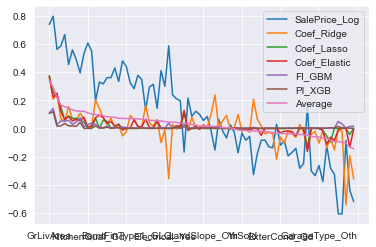

In [216]:
df_merged.plot()

In [217]:
df_merged_copy = df_merged.copy()

In [218]:
df_merged_copy = df_merged_copy.drop('SalePrice_Log', axis=1)

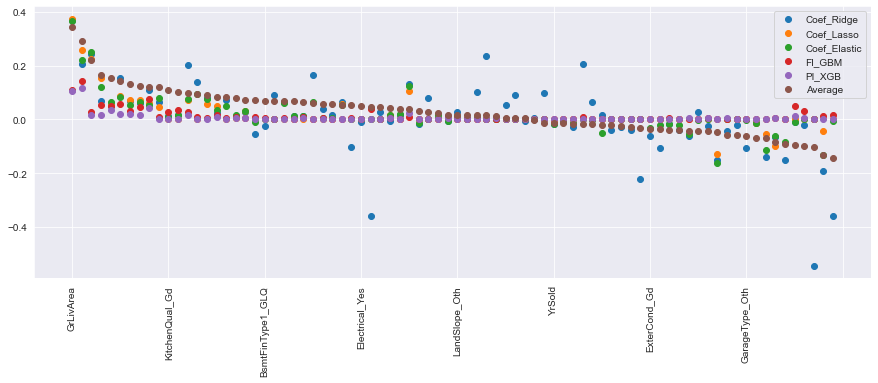

In [262]:
df_merged_copy.plot(figsize=(15,5), rot = 90, style='o-', linestyle='None')

In [263]:
# let's try to make this more attractive and readable

In [267]:
df_merged_copy.columns

Index(['Coef_Ridge', 'Coef_Lasso', 'Coef_Elastic', 'FI_GBM', 'PI_XGB',
       'Average'],
      dtype='object')

In [271]:
df_new = df_merged_copy.reset_index()

In [272]:
df_new.head()

,index,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB,Average
0,GrLivArea,0.370273,0.374660,0.366912,0.109338,0.106057,0.344360
1,OverallQual,0.206847,0.257456,0.221791,0.141431,0.118147,0.290490
2,NeighType_4,0.241809,0.224133,0.250810,0.028333,0.016088,0.220517
3,YearBuilt,0.068309,0.154035,0.121307,0.052467,0.017681,0.166613
4,Baths,0.048833,0.058619,0.063501,0.051363,0.034512,0.153914


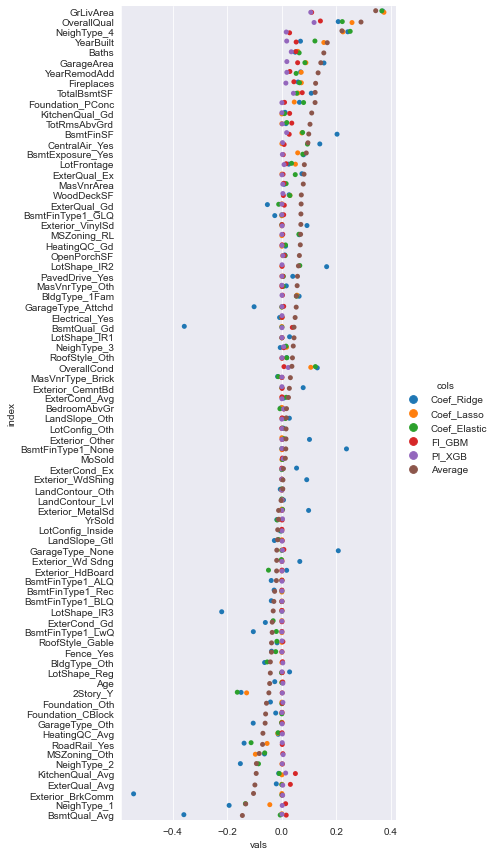

In [287]:
df_new_melt = df_new.melt('index', var_name='cols', value_name='vals')
g = sns.catplot(x='vals', y="index", hue="cols", data=df_new_melt, \
               height=12, aspect=0.5)

In [288]:
df_new_melt

,index,cols,vals
0,GrLivArea,Coef_Ridge,0.370273
1,OverallQual,Coef_Ridge,0.206847
2,NeighType_4,Coef_Ridge,0.241809
3,YearBuilt,Coef_Ridge,0.068309
4,Baths,Coef_Ridge,0.048833
5,GarageArea,Coef_Ridge,0.154518
6,YearRemodAdd,Coef_Ridge,0.068734
7,Fireplaces,Coef_Ridge,0.059411
8,TotalBsmtSF,Coef_Ridge,0.107884
9,Foundation_PConc,Coef_Ridge,0.064530


In [289]:
type(df_new_melt)

pandas.core.frame.DataFrame

In [290]:
df_new_melt = df_new_melt.sort_values(by='vals', ascending=False)

In [291]:
df_new_melt.head()

,index,cols,vals
80,GrLivArea,Coef_Lasso,0.374660
0,GrLivArea,Coef_Ridge,0.370273
160,GrLivArea,Coef_Elastic,0.366912
400,GrLivArea,Average,0.344360
401,OverallQual,Average,0.290490


In [292]:
df_new.head()

,index,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB,Average
0,GrLivArea,0.370273,0.374660,0.366912,0.109338,0.106057,0.344360
1,OverallQual,0.206847,0.257456,0.221791,0.141431,0.118147,0.290490
2,NeighType_4,0.241809,0.224133,0.250810,0.028333,0.016088,0.220517
3,YearBuilt,0.068309,0.154035,0.121307,0.052467,0.017681,0.166613
4,Baths,0.048833,0.058619,0.063501,0.051363,0.034512,0.153914


In [293]:
df_new['Avg_Abs'] = np.abs(df_new['Average'])

In [303]:
df_new.head(20)

,index,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB,Average,Avg_Abs
0,GrLivArea,0.370273,0.374660,0.366912,0.109338,0.106057,0.344360,0.344360
1,OverallQual,0.206847,0.257456,0.221791,0.141431,0.118147,0.290490,0.290490
2,NeighType_4,0.241809,0.224133,0.250810,0.028333,0.016088,0.220517,0.220517
3,YearBuilt,0.068309,0.154035,0.121307,0.052467,0.017681,0.166613,0.166613
4,Baths,0.048833,0.058619,0.063501,0.051363,0.034512,0.153914,0.153914
79,BsmtQual_Avg,-0.359775,-0.000000,-0.006163,0.015948,0.000407,-0.144953,0.144953
5,GarageArea,0.154518,0.088202,0.084509,0.057856,0.018235,0.142908,0.142908
6,YearRemodAdd,0.068734,0.070988,0.052299,0.029363,0.018171,0.132980,0.132980
78,NeighType_1,-0.193605,-0.044301,-0.133801,0.013773,0.001219,-0.132775,0.132775
7,Fireplaces,0.059411,0.071443,0.064669,0.044096,0.014699,0.123835,0.123835


In [300]:
df_new = df_new.sort_values(by='Avg_Abs', ascending=False)

In [302]:
df_new.head(20)

,index,Coef_Ridge,Coef_Lasso,Coef_Elastic,FI_GBM,PI_XGB,Average,Avg_Abs
0,GrLivArea,0.370273,0.374660,0.366912,0.109338,0.106057,0.344360,0.344360
1,OverallQual,0.206847,0.257456,0.221791,0.141431,0.118147,0.290490,0.290490
2,NeighType_4,0.241809,0.224133,0.250810,0.028333,0.016088,0.220517,0.220517
3,YearBuilt,0.068309,0.154035,0.121307,0.052467,0.017681,0.166613,0.166613
4,Baths,0.048833,0.058619,0.063501,0.051363,0.034512,0.153914,0.153914
79,BsmtQual_Avg,-0.359775,-0.000000,-0.006163,0.015948,0.000407,-0.144953,0.144953
5,GarageArea,0.154518,0.088202,0.084509,0.057856,0.018235,0.142908,0.142908
6,YearRemodAdd,0.068734,0.070988,0.052299,0.029363,0.018171,0.132980,0.132980
78,NeighType_1,-0.193605,-0.044301,-0.133801,0.013773,0.001219,-0.132775,0.132775
7,Fireplaces,0.059411,0.071443,0.064669,0.044096,0.014699,0.123835,0.123835


In [336]:
features_rank = df_new['index'].tolist()

In [315]:
features_ranked = df_new['index']

In [316]:
features_ranked

0             GrLivArea
1           OverallQual
2           NeighType_4
3             YearBuilt
4                 Baths
79         BsmtQual_Avg
5            GarageArea
6          YearRemodAdd
78          NeighType_1
7            Fireplaces
8           TotalBsmtSF
9      Foundation_PConc
10       KitchenQual_Gd
77     Exterior_BrkComm
11         TotRmsAbvGrd
76        ExterQual_Avg
12            BsmtFinSF
13       CentralAir_Yes
75      KitchenQual_Avg
74          NeighType_2
14     BsmtExposure_Yes
73         MSZoning_Oth
15          LotFrontage
16         ExterQual_Ex
17           MasVnrArea
18           WoodDeckSF
72         RoadRail_Yes
19         ExterQual_Gd
20     BsmtFinType1_GLQ
21     Exterior_VinylSd
71        HeatingQC_Avg
22          MSZoning_RL
23         HeatingQC_Gd
24          OpenPorchSF
70       GarageType_Oth
25         LotShape_IR2
69    Foundation_CBlock
26       PavedDrive_Yes
68       Foundation_Oth
27       MasVnrType_Oth
28        BldgType_1Fam
29    GarageType

In [317]:
features_ranked.reset_index(drop=True, inplace = True)

In [323]:
lis_feat_rank = list(features_ranked)

In [335]:
lis_feat_rank[:15]

['GrLivArea',
 'OverallQual',
 'NeighType_4',
 'YearBuilt',
 'Baths',
 'BsmtQual_Avg',
 'GarageArea',
 'YearRemodAdd',
 'NeighType_1',
 'Fireplaces',
 'TotalBsmtSF',
 'Foundation_PConc',
 'KitchenQual_Gd',
 'Exterior_BrkComm',
 'TotRmsAbvGrd']

In [326]:
# now lets iterate through MLR model and measure RMSE and R2 adding
# one feature at a time from most to least important

In [337]:
X_test = X.copy()

In [339]:
X_test = X_test.reindex(columns=features_rank)

In [341]:
X_test.head()

,GrLivArea,OverallQual,NeighType_4,YearBuilt,Baths,BsmtQual_Avg,GarageArea,YearRemodAdd,NeighType_1,Fireplaces,TotalBsmtSF,Foundation_PConc,KitchenQual_Gd,Exterior_BrkComm,TotRmsAbvGrd,ExterQual_Avg,BsmtFinSF,CentralAir_Yes,KitchenQual_Avg,NeighType_2,BsmtExposure_Yes,MSZoning_Oth,LotFrontage,ExterQual_Ex,MasVnrArea,WoodDeckSF,RoadRail_Yes,ExterQual_Gd,BsmtFinType1_GLQ,Exterior_VinylSd,HeatingQC_Avg,MSZoning_RL,HeatingQC_Gd,OpenPorchSF,GarageType_Oth,LotShape_IR2,Foundation_CBlock,PavedDrive_Yes,Foundation_Oth,MasVnrType_Oth,BldgType_1Fam,GarageType_Attchd,Electrical_Yes,2Story_Y,Age,BsmtQual_Gd,LotShape_IR1,LotShape_Reg,BldgType_Oth,NeighType_3,RoofStyle_Oth,Fence_Yes,RoofStyle_Gable,OverallCond,BsmtFinType1_LwQ,ExterCond_Gd,LotShape_IR3,MasVnrType_Brick,BsmtFinType1_BLQ,Exterior_CemntBd,BsmtFinType1_Rec,ExterCond_Avg,BsmtFinType1_ALQ,Exterior_HdBoard,Exterior_Wd Sdng,GarageType_None,BedroomAbvGr,LandSlope_Oth,LandSlope_Gtl,LotConfig_Oth,LotConfig_Inside,Exterior_Other,BsmtFinType1_None,MoSold,YrSold,Exterior_MetalSd,ExterCond_Ex,Exterior_WdShing,LandContour_Oth,LandContour_Lvl
0,0.507696,0.635894,0,1.040866,1.403943,0,0.332571,0.867181,0,-0.956888,-0.008553,1,1,0,0.946914,0,0.712844,1,0,0,0,0,-0.087249,0,0.506643,-0.755086,0,1,1,1,0,1,1,0.215804,0,0,0,1,0,0,1,1,1,1,-0.548883,1,0,1,0,1,0,0,1,-0.672868,0,0,0,1,0,0,0,1,0,0,0,0,0.207919,0,1,0,1,0,0,-1.599453,0.133833,0,0,0,0,1
1,-0.406099,-0.191125,1,0.137599,0.471662,0,0.220580,-0.451791,0,0.588597,0.339348,0,0,0,-0.218266,1,0.821346,1,1,0,1,0,0.580714,0,-0.570199,1.618445,1,0,0,0,0,1,1,-0.726764,0,0,1,1,0,0,1,1,1,0,-0.548883,1,0,1,0,0,0,0,1,2.342014,0,0,0,0,0,0,0,1,1,0,0,0,0.207919,0,1,1,0,0,0,-0.486221,-0.621834,1,0,0,0,1
2,0.641936,0.635894,0,0.973957,1.403943,0,0.400447,0.818331,0,0.588597,0.054546,1,1,0,-0.218266,0,0.594872,1,0,0,1,0,0.056137,0,0.319844,-0.755086,0,1,1,1,0,1,1,-0.077783,0,0,0,1,0,0,1,1,1,1,-0.507804,1,1,0,0,1,0,0,1,-0.672868,0,0,0,1,0,0,0,1,0,0,0,0,0.207919,0,1,0,1,0,0,0.998089,0.133833,0,0,0,0,1
3,0.520270,0.635894,0,-1.903116,-0.121166,1,0.436419,-0.744896,0,0.588597,-0.115679,0,1,0,0.399825,1,0.360334,1,0,0,0,0,-0.339236,0,-0.570199,-0.755086,0,0,0,0,0,1,1,-0.185946,1,0,0,1,1,0,1,0,1,1,1.710503,0,1,0,0,1,0,0,1,-0.672868,0,0,0,0,0,0,0,1,1,0,1,0,0.207919,0,1,1,0,0,0,-1.599453,-1.377502,0,0,0,0,1
4,1.294916,1.462914,1,0.940503,1.403943,0,0.615202,0.720629,0,0.588597,0.250239,1,1,0,1.438661,0,0.688622,1,0,0,1,0,0.740711,0,1.352734,0.774169,0,1,1,1,0,1,1,0.571199,0,0,0,1,0,0,1,1,1,1,-0.548883,1,1,0,0,0,0,0,1,-0.672868,0,0,0,1,0,0,0,1,0,0,0,0,0.769805,0,1,1,0,0,0,2.111321,0.133833,0,0,0,0,1


In [342]:
# so now we have X_test as the dataframe with the columns ranked in 
# the order of feature importance based on my averaging of the various
# importance terms from the regressions and trees

# now - let's iterate through them as a MLR adding one feature at a time
# and capturing the R2 and RMSE outputs to choose optimal number of
# features

In [343]:
# first I will save all this data and go to a new notebook
path_to_write = '~/Desktop/Ames_ML_Project/Data/sorted_df_01_24.csv'
X_test.to_csv(path_to_write)

In [344]:
path_to_write = '~/Desktop/Ames_ML_Project/Data/feature_terms_01_24.csv'
df_new.to_csv(path_to_write)

In [346]:
target_log_df = pd.DataFrame(target_log)
target_df = pd.DataFrame(target)

In [348]:
path_to_write = '~/Desktop/Ames_ML_Project/Data/target_log_01_24.csv'
target_log_df.to_csv(path_to_write)

In [349]:
path_to_write = '~/Desktop/Ames_ML_Project/Data/target_01_24.csv'
target_df.to_csv(path_to_write)